# Fine-tuning в Keras

В этом уроке мы научимся применять transfer learning и fine-tuning для известной нам задачи классификации кошек и собак. И наконец, добьемся качества около 95%!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#tf.enable_eager_execution()

BATCH_SIZE = 50
IMG_SHAPE  = 150

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

2024-05-03 16:27:21.113711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 16:27:22.035044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # указываем preprocessing_function !!!

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] + 1)/2., cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

In [4]:
IMG_SHAPE = (150, 150, 3)
# базовая модель -- MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # выуинуть последний слой из сети
                                               weights='imagenet')

base_model.trainable = False # замораживаем всю базовую модель
base_model.summary()

/tmp/ipykernel_100194/997380277.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
2024-05-03 16:29:40.934580: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 16:29:40.982680: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-03 16:29:40.982936: I external/local_xla/xla/

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

In [9]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

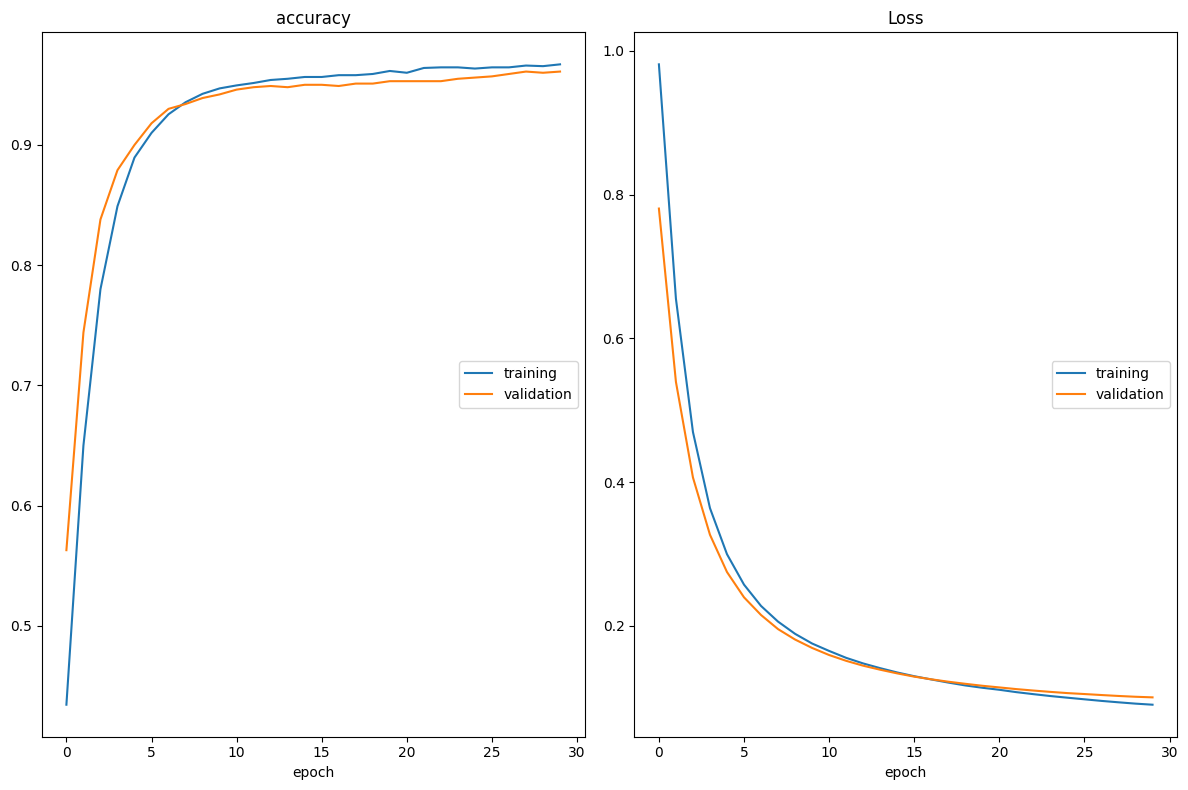

accuracy
	training         	 (min:    0.435, max:    0.967, cur:    0.967)
	validation       	 (min:    0.563, max:    0.961, cur:    0.961)
Loss
	training         	 (min:    0.091, max:    0.981, cur:    0.091)
	validation       	 (min:    0.101, max:    0.781, cur:    0.101)
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9665 - loss: 0.0943 - val_accuracy: 0.9610 - val_loss: 0.1007


In [12]:
EPOCHS = 30
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [14]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  154


In [17]:
fine_tune_at = 100
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), # уменьшили скорость обучения
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

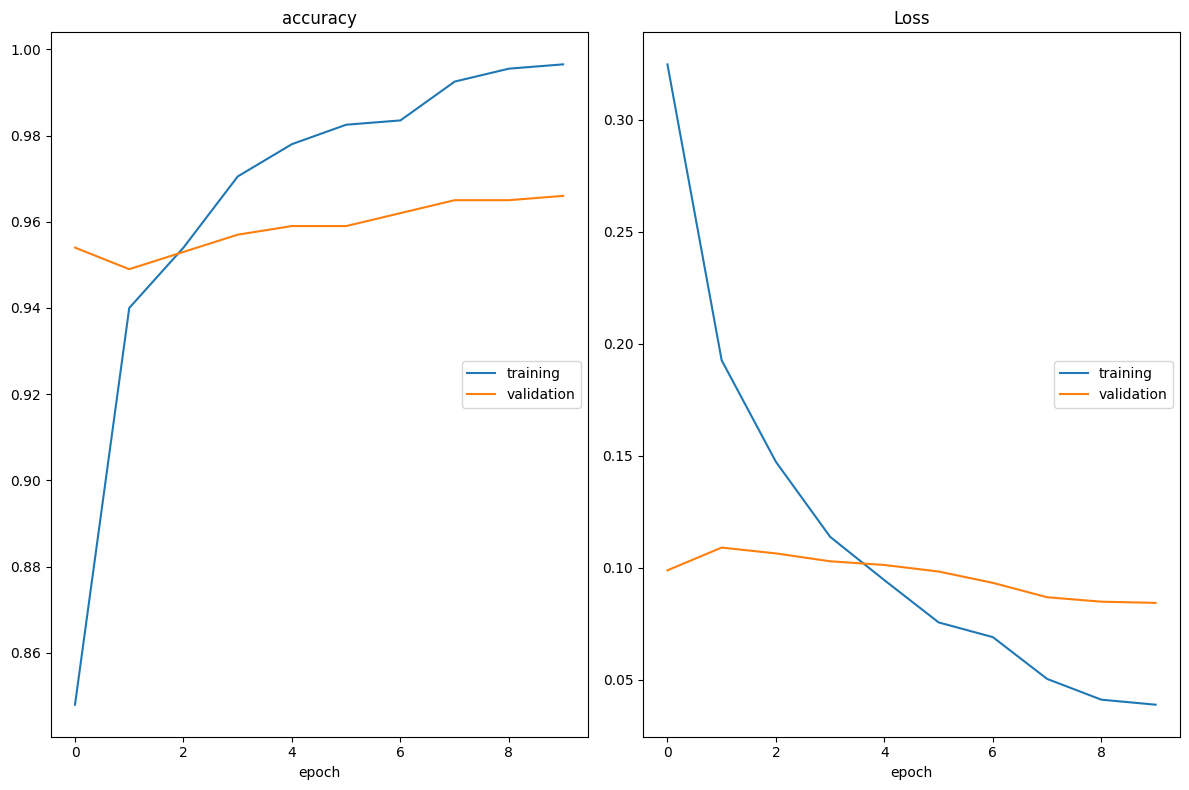

accuracy
	training         	 (min:    0.848, max:    0.997, cur:    0.997)
	validation       	 (min:    0.949, max:    0.966, cur:    0.966)
Loss
	training         	 (min:    0.039, max:    0.325, cur:    0.039)
	validation       	 (min:    0.084, max:    0.109, cur:    0.084)
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9943 - loss: 0.0425 - val_accuracy: 0.9660 - val_loss: 0.0843


In [19]:
EPOCHS = 10
history = model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [1]:
sample_validation_images, sample_validation_labels = next(val_data_gen)
predicted = (model.predict(sample_validation_images) > 0.5).astype("int32").flatten()


show_catsdogs(sample_validation_images, sample_validation_labels, predicted)

NameError: name 'val_data_gen' is not defined

# Заключение

В этом модуле вы познакомились со сверточными нейронными сетями и современными подходами к их обучению. В домашнем задании вы воспользуетесь всеми полученными знаниями для реализации классификатора пола и расы людей по фотографии! Удачи!